In [1]:
import itertools
import os

from deepface import DeepFace
from chefboost import Chefboost as cb
import pandas as pd
from tqdm import tqdm

In [2]:
cases = [
    ("dataset/img1.jpg", "dataset/img2.jpg", True),
    ("dataset/img1.jpg", "dataset/img3.jpg", False),
]

for case in cases:
    result = DeepFace.verify(
        img1_path=case[0],
        img2_path=case[1],
        model_name="GhostFaceNet",
        distance_metric="cosine",
        # detector_backend="mtcnn",
    )
    assert result["verified"] == case[2]

# Monitor Distributions

In [2]:
distance_metrics = ["cosine", "euclidean", "euclidean_l2"]

idendities = {
    "Angelina": ["img1.jpg", "img2.jpg", "img4.jpg"
    , "img5.jpg", "img6.jpg", "img7.jpg", "img10.jpg", "img11.jpg"],
    "Scarlett": ["img8.jpg", "img9.jpg"],
    "Jennifer": ["img3.jpg", "img12.jpg"],
    "Mark": ["img13.jpg", "img14.jpg", "img15.jpg"],
    "Jack": ["img16.jpg", "img17.jpg"],
    "Elon": ["img18.jpg", "img19.jpg"],
    "Jeff": ["img20.jpg", "img21.jpg"],
    "Marissa": ["img22.jpg", "img23.jpg"],
    "Sundar": ["img24.jpg", "img25.jpg"]
}

In [3]:
def load_df():
    positives = []
    for key, values in idendities.items():
        for i in range(0, len(values)-1):
            for j in range(i+1, len(values)):
                positive = []
                positive.append(values[i])
                positive.append(values[j])
                positives.append(positive)
    
    positives = pd.DataFrame(positives, columns = ["file_x", "file_y"])
    positives["decision"] = "Yes"

    samples_list = list(idendities.values())
    
    negatives = []
    for i in range(0, len(idendities) - 1):
        for j in range(i+1, len(idendities)):
            cross_product = itertools.product(samples_list[i], samples_list[j])
            cross_product = list(cross_product)
    
            for cross_sample in cross_product:
                negative = []
                negative.append(cross_sample[0])
                negative.append(cross_sample[1])
                negatives.append(negative)
    
    negatives = pd.DataFrame(negatives, columns = ["file_x", "file_y"])
    negatives["decision"] = "No"

    df = pd.concat([positives, negatives]).reset_index(drop = True)
    
    df.file_x = "dataset/"+df.file_x
    df.file_y = "dataset/"+df.file_y

    return df

In [4]:
df = load_df()

In [5]:
df.head()

,file_x,file_y,decision
0,dataset/img1.jpg,dataset/img2.jpg,Yes
1,dataset/img1.jpg,dataset/img4.jpg,Yes
2,dataset/img1.jpg,dataset/img5.jpg,Yes
3,dataset/img1.jpg,dataset/img6.jpg,Yes
4,dataset/img1.jpg,dataset/img7.jpg,Yes


In [6]:
for distance_metric in distance_metrics:
    target_file = f"ghostfacenet_{distance_metric}.csv"
    if os.path.exists(target_file):
        continue

    distances = []
    for index, instance in tqdm(df.iterrows(), total=df.shape[0]):
        result = DeepFace.verify(
            img1_path=instance.file_x,
            img2_path=instance.file_y,
            model_name="GhostFaceNet",
            distance_metric=distance_metric,
            # detector_backend="mtcnn",
        )
        distance = result["distance"]
        actual = instance.decision

        distances.append((instance.file_x, instance.file_y, distance, actual))
    
    distances_df = pd.DataFrame(distances, columns=["x", "y", "distance", "label"])
    distances_df.to_csv(target_file, index=False)

<AxesSubplot:ylabel='Density'>

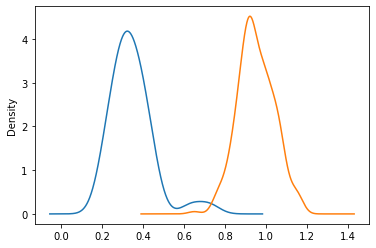

In [15]:
pivot_df = pd.read_csv("ghostfacenet_cosine.csv")
# pivot_df = pivot_df.drop(columns=["x", "y"])
pivot_df[pivot_df.label == "Yes"].distance.plot.kde()
pivot_df[pivot_df.label == "No"].distance.plot.kde()

# acc: 99.33333333333333, threshold: 0.6528872393856355

In [16]:
pivot_df[(pivot_df["distance"] > 0.65) & (pivot_df["label"] == "Yes") ]

,x,y,distance,label
37,dataset/img24.jpg,dataset/img25.jpg,0.722837,Yes


In [17]:
pivot_df[(pivot_df["distance"] <= 0.65) & (pivot_df["label"] == "No") ]

,x,y,distance,label
196,dataset/img8.jpg,dataset/img22.jpg,0.649719,No


In [18]:
298/300

0.9933333333333333

In [ ]:
# cb.fit(pivot_df, target_label="label", config={"algorithm": "C4.5", "enableParallelism": False})

<AxesSubplot:ylabel='Density'>

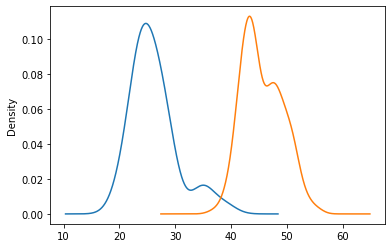

In [11]:
pivot_df = pd.read_csv("ghostfacenet_euclidean.csv")
# pivot_df = pivot_df.drop(columns=["x", "y"])
pivot_df[pivot_df.label == "Yes"].distance.plot.kde()
pivot_df[pivot_df.label == "No"].distance.plot.kde()

# 35.710661466705986

In [12]:
pivot_df[(pivot_df["distance"] > 35.71) & (pivot_df["label"] == "Yes") ]

,x,y,distance,label
37,dataset/img24.jpg,dataset/img25.jpg,38.902903,Yes


In [13]:
pivot_df[(pivot_df["distance"] <= 35.71) & (pivot_df["label"] == "No") ]

,x,y,distance,label


In [14]:
299/300

0.9966666666666667

In [ ]:
# cb.fit(pivot_df, target_label="label", config={"algorithm": "C4.5", "enableParallelism": False})

<AxesSubplot:ylabel='Density'>

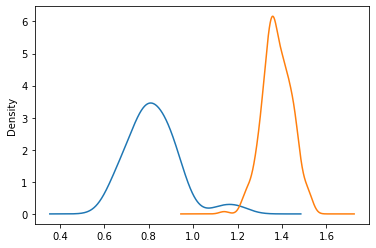

In [19]:
pivot_df = pd.read_csv("ghostfacenet_euclidean_l2.csv")
# pivot_df = pivot_df.drop(columns=["x", "y"])
pivot_df[pivot_df.label == "Yes"].distance.plot.kde()
pivot_df[pivot_df.label == "No"].distance.plot.kde()

# 1.1083420910814596

In [ ]:
# cb.fit(pivot_df, target_label="label", config={"algorithm": "C4.5", "enableParallelism": False})

In [20]:
pivot_df[(pivot_df["distance"] > 1.10) & (pivot_df["label"] == "Yes") ]

,x,y,distance,label
29,dataset/img3.jpg,dataset/img12.jpg,1.126750,Yes
37,dataset/img24.jpg,dataset/img25.jpg,1.202362,Yes


In [21]:
pivot_df[(pivot_df["distance"] <= 1.10) & (pivot_df["label"] == "No") ]

,x,y,distance,label
